In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import yfinance as yf

In [ ]:
pip install --upgrade yfinance

In [ ]:
data=yf.Ticker("AAPL")
stock_history=pd.DataFrame(data.history(period="5y"))
#convert the date in the data to datetime#
stock_history
stock_history.reset_index(inplace=True)
stock_history['Date'] =stock_history['Date'].dt.strftime('%Y/%m/%d')
train_dates=pd.to_datetime(stock_history['Date'])
print(stock_history)

            Date        Open        High         Low       Close     Volume  \
0     2018/12/10   39.592207   40.813566   39.191487   40.695992  248104000   
1     2018/12/11   41.190294   41.221486   40.072114   40.463238  189126800   
2     2018/12/12   40.887943   41.252673   40.556811   40.576008  142510800   
3     2018/12/13   40.909533   41.408635   40.683977   41.019909  127594400   
4     2018/12/14   40.552009   40.571206   39.659385   39.707375  162814800   
...          ...         ...         ...         ...         ...        ...   
1254  2023/12/04  189.979996  190.050003  187.449997  189.429993   43389500   
1255  2023/12/05  190.210007  194.399994  190.179993  193.419998   66628400   
1256  2023/12/06  194.449997  194.759995  192.110001  192.320007   41089700   
1257  2023/12/07  193.630005  195.000000  193.589996  194.270004   47477700   
1258  2023/12/08  194.199997  195.990005  193.669998  195.710007   53377300   

      Dividends  Stock Splits  
0           0.0    

-

In [ ]:

ticker="NU"
#grab the data from yahoo finance
data=yf.Ticker(ticker)
stock_history=data.history(period="5y")

#convert the date in the data to datetime
stock_history.reset_index(inplace=True)
stock_history['Date'] =stock_history['Date'].dt.strftime('%Y/%m/%d')
train_dates=pd.to_datetime(stock_history['Date'])

#get the cols for training
cols=list(stock_history)[1:6]
stock_history.isnull().values.any()
df_fortraining=stock_history[cols].astype(float)

print(cols)

['Open', 'High', 'Low', 'Close', 'Volume']


In [ ]:
def stacked_lstm(ticker,nodes,drop,epochs):

  #grab the data from yahoo finance
  data=yf.Ticker(ticker)
  stock_history=data.history(period="20y")

  #convert the date in the data to datetime
  stock_history.reset_index(inplace=True)
  stock_history['Date'] =stock_history['Date'].dt.strftime('%Y/%m/%d')
  train_dates=pd.to_datetime(stock_history['Date'])

  #get the cols for training
  cols=list(stock_history)[1:6]
  stock_history.isnull().values.any()
  df_fortraining=stock_history[cols].astype(float)

  #standerdize data
  scaler=StandardScaler()
  scaler=scaler.fit(df_fortraining)
  df_scaled=scaler.transform(df_fortraining)

  trainX=[]
  trainY=[]

  n_future=1 # number of days we want to predict
  n_past=14 # number of days in past we want to use to make prediction

  for i in range(n_past, len(df_scaled) - n_future +1):
      trainX.append(df_scaled[i - n_past:i, 0:df_scaled.shape[1]])
      trainY.append(df_scaled[i + n_future - 1:i + n_future, 3])

  #convert to numpy array - which will change dimensions cause trainX is a list of lists rn
  trainX,trainY=np.array(trainX),np.array(trainY)

  #nodes=[50,50,100,100]
  # drop=0.7000000000000002

  model = tf.keras.Sequential([
  tf.keras.layers.LSTM(nodes[0], activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  tf.keras.layers.LSTM(nodes[1], activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(nodes[2], activation='relu', return_sequences=True),
  #tf.keras.layers.LSTM(nodes[0], activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  #tf.keras.layers.LSTM(nodes[1], activation='relu', return_sequences=True),
  #tf.keras.layers.LSTM(nodes[2], activation='relu', return_sequences=True),
  #tf.keras.layers.LSTM(nodes[3], activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(nodes[3], activation='relu', return_sequences=False),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(500, activation='relu'),
  #tf.keras.layers.Dense(500, activation='relu'),
 #tf.keras.layers.Dense(500, activation='relu'),
  #tf.keras.layers.Dense(3000, activation='relu'),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(trainY.shape[1])
  ])
  epochs=epochs
  # Define a learning rate schedule
  learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001/epochs,
  decay_steps=10000,
  decay_rate=0.96
  )

  # Create an optimizer with the learning rate schedule
  optimizers = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

  model.compile(optimizer=optimizers,loss='mean_squared_error')
  history=model.fit(
      trainX,
      trainY,
      validation_split=0.2,
      epochs=epochs,
    )

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  n_futures=90
  #train_dates[-1] is the current date or last date in the data, going till 90 days past
  forecast_period_dates = pd.date_range(list(train_dates)[-10], periods=n_futures, freq='1d').tolist()
  print(forecast_period_dates)

  #predict
  # use [-n_futures] becasue this is -90 which means take 90th last day as the starting date for the sequence then that day till the end of dataset(current date) to get 91st which is the output 1(1st day of 90 days or current date +1) then take the last 90th plus one so the 89th last day till the current date +1, which will predict the current day +2, do this until you are using last part of dataset(ie. current date) to current date+89 to get the current+90th day
  forecast=model.predict(trainX[-n_futures:])

  #forecasts_results.append(forecast)
  model.save_weights('%s.h5' % ticker)

  prediction_copies = np.repeat(forecast, df_fortraining.shape[1], axis=-1)
  y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
  #print(y_pred_future)
  forecast_dates = []
  for time_i in forecast_period_dates:
      forecast_dates.append(time_i.date())
  df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
  df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
  print(model.summary())
  return df_forecast




In [ ]:
# nodes=[500,500,500,500]
# drop=0.7
# stacked_lstm('NET',nodes,drop,100)

In [ ]:
#run the above function on every stock that we chose -- maybe just add them to a list
Ticker_List= ['SITM','MDB','SHOP','NET',
'ROKU',
'MLM',
'LIN',
'NBR',
'TPL',
'PECO',
'MELI',
'TSLA',
'MSEX',
'AWR',
'NWN',
'SJW',
'CPK',
'OTTR',
'CWT',
'UTL',
'COST',
'ELF',
'CUBI']

In [ ]:
nodes=[500,500,500,500]
drop=0.4
SITM=stacked_lstm('SITM',nodes,drop,50)


Epoch 1/50
26/26 [==============================] - 11s 119ms/step - loss: 1.2007 - val_loss: 0.0410
Epoch 2/50
26/26 [==============================] - 2s 80ms/step - loss: 1.1323 - val_loss: 0.0371
Epoch 3/50
26/26 [==============================] - 2s 79ms/step - loss: 0.7512 - val_loss: 0.0246
Epoch 4/50
26/26 [==============================] - 2s 80ms/step - loss: 0.2833 - val_loss: 0.0243
Epoch 5/50
26/26 [==============================] - 2s 81ms/step - loss: 0.1908 - val_loss: 0.0260
Epoch 6/50
26/26 [==============================] - 2s 83ms/step - loss: 0.1497 - val_loss: 0.0299
Epoch 7/50
26/26 [==============================] - 2s 80ms/step - loss: 0.1443 - val_loss: 0.0316
Epoch 8/50
26/26 [==============================] - 2s 79ms/step - loss: 0.1322 - val_loss: 0.0370
Epoch 9/50
26/26 [==============================] - 2s 81ms/step - loss: 0.1246 - val_loss: 0.0377
Epoch 10/50
26/26 [==============================] - 2s 81ms/step - loss: 0.1195 - val_loss: 0.0385
Epoch 1

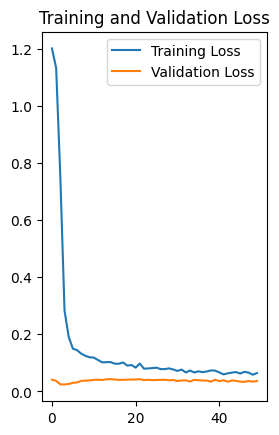

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
39/39 [==============================] - 9s 93ms/step - loss: 1.0530 - val_loss: 0.6039
Epoch 2/50
39/39 [==============================] - 3s 81ms/step - loss: 0.7668 - val_loss: 0.3978
Epoch 3/50
39/39 [==============================] - 3s 81ms/step - loss: 0.1952 - val_loss: 0.1222
Epoch 4/50
39/39 [==============================] - 3s 79ms/step - loss: 0.1162 - val_loss: 0.0714
Epoch 5/50
39/39 [==============================] - 3s 79ms/step - loss: 0.0942 - val_loss: 0.0655
Epoch 6/50
39/39 [==============================] - 3s 80ms/step - loss: 0.0987 - val_loss: 0.0682
Epoch 7/50
39/39 [==============================] - 3s 79ms/step - loss: 0.0852 - val_loss: 0.0596
Epoch 8/50
39/39 [==============================] - 3s 77ms/step - loss: 0.0827 - val_loss: 0.0664
Epoch 9/50
39/39 [==============================] - 3s 79ms/step - loss: 0.0765 - val_loss: 0.0539
Epoch 10/50
39/39 [==============================] - 3s 81ms/step - loss: 0.0774 - val_loss: 0.0560
Epoch 11/

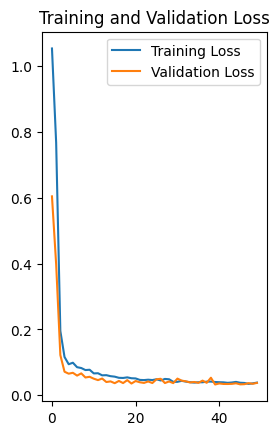

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
54/54 [==============================] - 10s 91ms/step - loss: 1.1601 - val_loss: 0.0792
Epoch 2/50
54/54 [==============================] - 4s 81ms/step - loss: 0.5068 - val_loss: 0.0311
Epoch 3/50
54/54 [==============================] - 4s 81ms/step - loss: 0.0934 - val_loss: 0.0260
Epoch 4/50
54/54 [==============================] - 4s 80ms/step - loss: 0.0617 - val_loss: 0.0255
Epoch 5/50
54/54 [==============================] - 4s 81ms/step - loss: 0.0510 - val_loss: 0.0243
Epoch 6/50
54/54 [==============================] - 4s 80ms/step - loss: 0.0496 - val_loss: 0.0239
Epoch 7/50
54/54 [==============================] - 4s 80ms/step - loss: 0.0465 - val_loss: 0.0235
Epoch 8/50
54/54 [==============================] - 4s 81ms/step - loss: 0.0503 - val_loss: 0.0245
Epoch 9/50
54/54 [==============================] - 4s 80ms/step - loss: 0.0435 - val_loss: 0.0234
Epoch 10/50
54/54 [==============================] - 4s 82ms/step - loss: 0.0454 - val_loss: 0.0236
Epoch 11

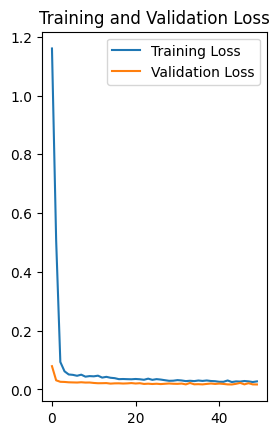

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
27/27 [==============================] - 8s 101ms/step - loss: 1.2163 - val_loss: 0.0459
Epoch 2/50
27/27 [==============================] - 2s 76ms/step - loss: 1.1435 - val_loss: 0.0425
Epoch 3/50
27/27 [==============================] - 2s 76ms/step - loss: 0.7603 - val_loss: 0.0291
Epoch 4/50
27/27 [==============================] - 2s 80ms/step - loss: 0.2414 - val_loss: 0.0323
Epoch 5/50
27/27 [==============================] - 2s 81ms/step - loss: 0.1735 - val_loss: 0.0343
Epoch 6/50
27/27 [==============================] - 2s 81ms/step - loss: 0.1891 - val_loss: 0.0362
Epoch 7/50
27/27 [==============================] - 2s 77ms/step - loss: 0.1479 - val_loss: 0.0340
Epoch 8/50
27/27 [==============================] - 2s 79ms/step - loss: 0.1553 - val_loss: 0.0334
Epoch 9/50
27/27 [==============================] - 2s 77ms/step - loss: 0.1263 - val_loss: 0.0328
Epoch 10/50
27/27 [==============================] - 2s 79ms/step - loss: 0.1430 - val_loss: 0.0336
Epoch 11

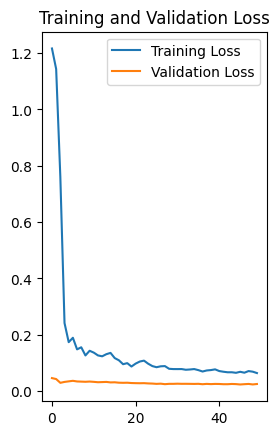

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
39/39 [==============================] - 8s 93ms/step - loss: 1.1235 - val_loss: 0.3720
Epoch 2/50
39/39 [==============================] - 3s 79ms/step - loss: 0.7654 - val_loss: 0.2830
Epoch 3/50
39/39 [==============================] - 3s 78ms/step - loss: 0.1622 - val_loss: 0.0333
Epoch 4/50
39/39 [==============================] - 3s 77ms/step - loss: 0.0886 - val_loss: 0.0106
Epoch 5/50
39/39 [==============================] - 3s 80ms/step - loss: 0.0839 - val_loss: 0.0080
Epoch 6/50
39/39 [==============================] - 3s 78ms/step - loss: 0.0764 - val_loss: 0.0085
Epoch 7/50
39/39 [==============================] - 3s 78ms/step - loss: 0.0754 - val_loss: 0.0071
Epoch 8/50
39/39 [==============================] - 3s 76ms/step - loss: 0.0758 - val_loss: 0.0069
Epoch 9/50
39/39 [==============================] - 3s 81ms/step - loss: 0.0671 - val_loss: 0.0064
Epoch 10/50
39/39 [==============================] - 3s 77ms/step - loss: 0.0645 - val_loss: 0.0065
Epoch 11/

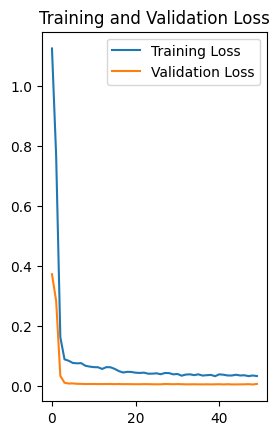

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 82ms/step - loss: 0.2463 - val_loss: 2.9778
Epoch 2/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0292 - val_loss: 0.0963
Epoch 3/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0124 - val_loss: 0.3263
Epoch 4/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0112 - val_loss: 0.7298
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0110 - val_loss: 1.0786
Epoch 6/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0099 - val_loss: 1.1220
Epoch 7/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0095 - val_loss: 1.0931
Epoch 8/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0095 - val_loss: 1.1875
Epoch 9/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0089 - val_loss: 1.2566
Epoch 10/50
126/126 [==============================] - 10s 78ms/step - loss: 0.008

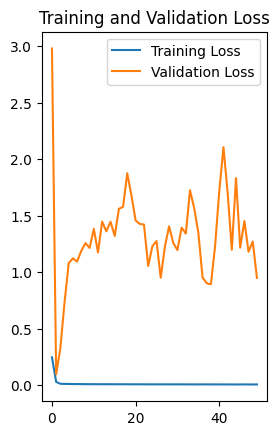

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 82ms/step - loss: 0.1926 - val_loss: 3.3538
Epoch 2/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0216 - val_loss: 0.0838
Epoch 3/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0089 - val_loss: 0.3942
Epoch 4/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0083 - val_loss: 0.5554
Epoch 5/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0071 - val_loss: 0.2921
Epoch 6/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0068 - val_loss: 0.4374
Epoch 7/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0065 - val_loss: 0.3478
Epoch 8/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0065 - val_loss: 0.4912
Epoch 9/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0062 - val_loss: 0.3206
Epoch 10/50
126/126 [==============================] - 10s 78ms/step - loss: 0.005

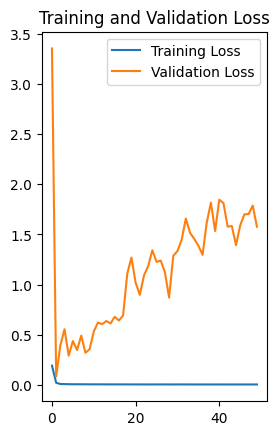

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 83ms/step - loss: 0.4848 - val_loss: 0.3494
Epoch 2/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0567 - val_loss: 0.0050
Epoch 3/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0443 - val_loss: 0.0144
Epoch 4/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0409 - val_loss: 0.0096
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0362 - val_loss: 0.0123
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0341 - val_loss: 0.0106
Epoch 7/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0323 - val_loss: 0.0120
Epoch 8/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0299 - val_loss: 0.0253
Epoch 9/50
126/126 [==============================] - 10s 77ms/step - loss: 0.0304 - val_loss: 0.0095
Epoch 10/50
126/126 [==============================] - 10s 78ms/step - loss: 0.028

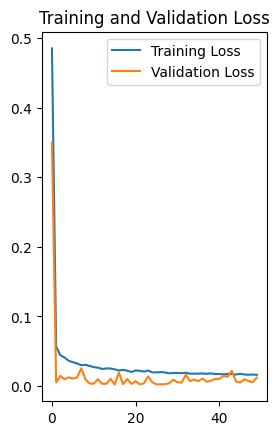

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 83ms/step - loss: 0.1566 - val_loss: 2.7741
Epoch 2/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0109 - val_loss: 10.2803
Epoch 3/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0067 - val_loss: 8.7024
Epoch 4/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0060 - val_loss: 7.3700
Epoch 5/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0060 - val_loss: 5.5363
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0056 - val_loss: 5.0573
Epoch 7/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0052 - val_loss: 5.1766
Epoch 8/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0051 - val_loss: 5.9462
Epoch 9/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0047 - val_loss: 6.5175
Epoch 10/50
126/126 [==============================] - 10s 78ms/step - loss: 0.00

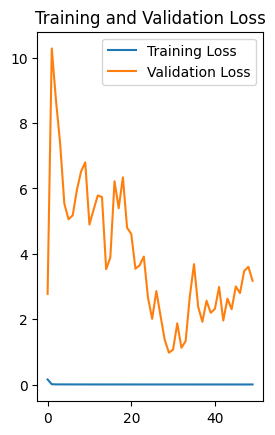

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
18/18 [==============================] - 7s 112ms/step - loss: 0.9803 - val_loss: 0.4974
Epoch 2/50
18/18 [==============================] - 1s 79ms/step - loss: 0.9614 - val_loss: 0.4851
Epoch 3/50
18/18 [==============================] - 1s 80ms/step - loss: 0.9169 - val_loss: 0.4591
Epoch 4/50
18/18 [==============================] - 1s 82ms/step - loss: 0.7330 - val_loss: 0.3983
Epoch 5/50
18/18 [==============================] - 1s 83ms/step - loss: 0.2161 - val_loss: 0.2498
Epoch 6/50
18/18 [==============================] - 1s 81ms/step - loss: 0.0846 - val_loss: 0.0297
Epoch 7/50
18/18 [==============================] - 1s 80ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 8/50
18/18 [==============================] - 1s 79ms/step - loss: 0.0814 - val_loss: 0.0582
Epoch 9/50
18/18 [==============================] - 1s 79ms/step - loss: 0.0824 - val_loss: 0.0585
Epoch 10/50
18/18 [==============================] - 1s 79ms/step - loss: 0.0792 - val_loss: 0.0525
Epoch 11

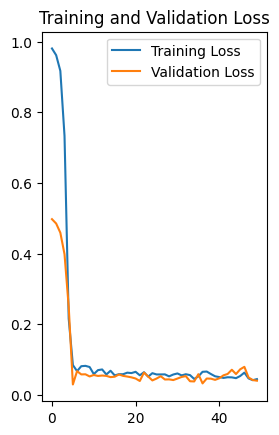

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
103/103 [==============================] - 17s 88ms/step - loss: 0.2299 - val_loss: 3.4356
Epoch 2/50
103/103 [==============================] - 8s 81ms/step - loss: 0.0455 - val_loss: 1.2321
Epoch 3/50
103/103 [==============================] - 8s 82ms/step - loss: 0.0129 - val_loss: 1.2775
Epoch 4/50
103/103 [==============================] - 8s 82ms/step - loss: 0.0095 - val_loss: 1.0434
Epoch 5/50
103/103 [==============================] - 8s 81ms/step - loss: 0.0087 - val_loss: 0.9167
Epoch 6/50
103/103 [==============================] - 8s 79ms/step - loss: 0.0082 - val_loss: 1.3131
Epoch 7/50
103/103 [==============================] - 8s 80ms/step - loss: 0.0083 - val_loss: 1.4733
Epoch 8/50
103/103 [==============================] - 8s 80ms/step - loss: 0.0077 - val_loss: 1.1017
Epoch 9/50
103/103 [==============================] - 8s 79ms/step - loss: 0.0075 - val_loss: 1.3962
Epoch 10/50
103/103 [==============================] - 8s 80ms/step - loss: 0.0077 - val_l

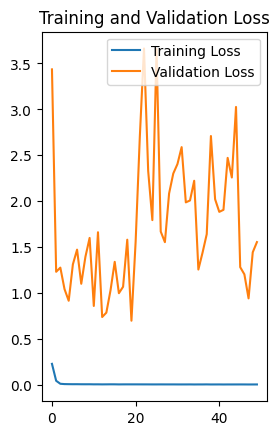

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
85/85 [==============================] - 12s 87ms/step - loss: 0.3260 - val_loss: 3.1784
Epoch 2/50
85/85 [==============================] - 7s 81ms/step - loss: 0.0651 - val_loss: 0.6835
Epoch 3/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0187 - val_loss: 0.5162
Epoch 4/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0156 - val_loss: 0.3468
Epoch 5/50
85/85 [==============================] - 7s 78ms/step - loss: 0.0156 - val_loss: 0.3374
Epoch 6/50
85/85 [==============================] - 7s 81ms/step - loss: 0.0124 - val_loss: 0.4045
Epoch 7/50
85/85 [==============================] - 7s 79ms/step - loss: 0.0115 - val_loss: 0.2800
Epoch 8/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0123 - val_loss: 0.3422
Epoch 9/50
85/85 [==============================] - 7s 81ms/step - loss: 0.0107 - val_loss: 0.2120
Epoch 10/50
85/85 [==============================] - 7s 79ms/step - loss: 0.0097 - val_loss: 0.3129
Epoch 11

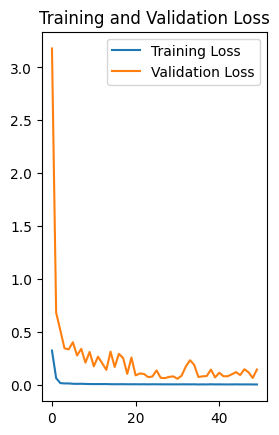

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 84ms/step - loss: 0.2529 - val_loss: 1.2303
Epoch 2/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0152 - val_loss: 0.4444
Epoch 3/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0102 - val_loss: 0.2046
Epoch 4/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0090 - val_loss: 0.1970
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0082 - val_loss: 0.4393
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0077 - val_loss: 0.5785
Epoch 7/50
126/126 [==============================] - 10s 81ms/step - loss: 0.0074 - val_loss: 1.3482
Epoch 8/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0072 - val_loss: 1.3304
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0067 - val_loss: 1.8216
Epoch 10/50
126/126 [==============================] - 10s 80ms/step - loss: 0.006

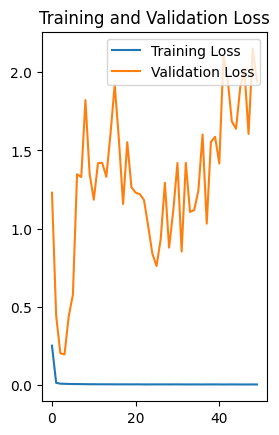

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 82ms/step - loss: 0.3290 - val_loss: 0.1770
Epoch 2/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0219 - val_loss: 0.0354
Epoch 3/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0146 - val_loss: 0.0734
Epoch 4/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0133 - val_loss: 0.0276
Epoch 5/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0126 - val_loss: 0.0675
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0112 - val_loss: 0.0404
Epoch 7/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0108 - val_loss: 0.0292
Epoch 8/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0099 - val_loss: 0.0237
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0093 - val_loss: 0.0376
Epoch 10/50
126/126 [==============================] - 10s 79ms/step - loss: 0.009

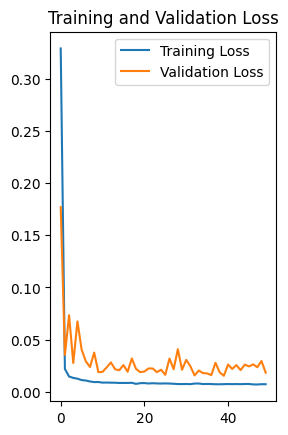

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 83ms/step - loss: 0.5488 - val_loss: 0.0936
Epoch 2/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0431 - val_loss: 0.0758
Epoch 3/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0337 - val_loss: 0.0654
Epoch 4/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0300 - val_loss: 0.0598
Epoch 5/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0282 - val_loss: 0.0561
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0272 - val_loss: 0.0509
Epoch 7/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0248 - val_loss: 0.0507
Epoch 8/50
126/126 [==============================] - 10s 81ms/step - loss: 0.0226 - val_loss: 0.0442
Epoch 9/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0223 - val_loss: 0.0427
Epoch 10/50
126/126 [==============================] - 10s 79ms/step - loss: 0.021

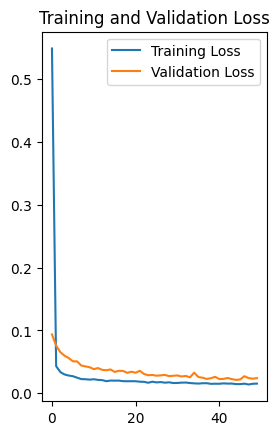

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 83ms/step - loss: 0.3923 - val_loss: 12.2518
Epoch 2/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0253 - val_loss: 0.1827
Epoch 3/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0180 - val_loss: 0.1666
Epoch 4/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0167 - val_loss: 0.2193
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0152 - val_loss: 0.1311
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0142 - val_loss: 0.1385
Epoch 7/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0140 - val_loss: 0.1016
Epoch 8/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0135 - val_loss: 0.1380
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0127 - val_loss: 0.1064
Epoch 10/50
126/126 [==============================] - 10s 80ms/step - loss: 0.01

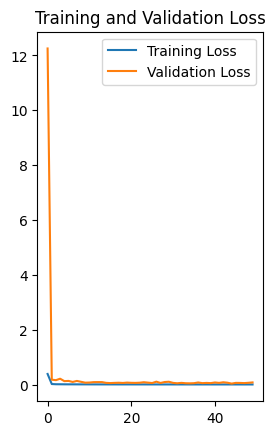

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 83ms/step - loss: 0.3085 - val_loss: 11.8676
Epoch 2/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0172 - val_loss: 0.7309
Epoch 3/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0122 - val_loss: 0.8338
Epoch 4/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0118 - val_loss: 0.8788
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0103 - val_loss: 0.9277
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0099 - val_loss: 0.8388
Epoch 7/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0101 - val_loss: 1.0204
Epoch 8/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0090 - val_loss: 0.8008
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0084 - val_loss: 0.8510
Epoch 10/50
126/126 [==============================] - 10s 80ms/step - loss: 0.00

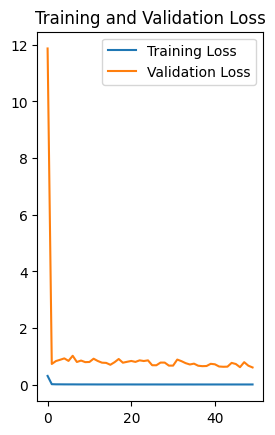

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 84ms/step - loss: 0.2662 - val_loss: 1.9093
Epoch 2/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0180 - val_loss: 1.6452
Epoch 3/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0116 - val_loss: 1.8554
Epoch 4/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0096 - val_loss: 1.0084
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0094 - val_loss: 0.7241
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0090 - val_loss: 0.7779
Epoch 7/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0084 - val_loss: 0.7367
Epoch 8/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0083 - val_loss: 0.7781
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0084 - val_loss: 3.5605
Epoch 10/50
126/126 [==============================] - 10s 79ms/step - loss: 0.007

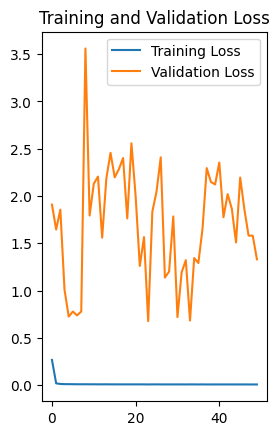

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 16s 84ms/step - loss: 0.3338 - val_loss: 0.5214
Epoch 2/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0229 - val_loss: 0.1120
Epoch 3/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0144 - val_loss: 0.1147
Epoch 4/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0125 - val_loss: 0.1043
Epoch 5/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0112 - val_loss: 0.3598
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0117 - val_loss: 0.0990
Epoch 7/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0103 - val_loss: 0.0964
Epoch 8/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0095 - val_loss: 0.2202
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0102 - val_loss: 0.0561
Epoch 10/50
126/126 [==============================] - 10s 80ms/step - loss: 0.009

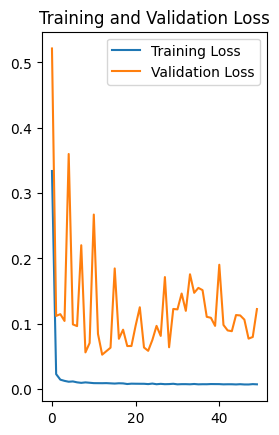

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 15s 84ms/step - loss: 0.4381 - val_loss: 0.2857
Epoch 2/50
126/126 [==============================] - 10s 81ms/step - loss: 0.0283 - val_loss: 0.0724
Epoch 3/50
126/126 [==============================] - 10s 81ms/step - loss: 0.0217 - val_loss: 0.0454
Epoch 4/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0178 - val_loss: 0.0422
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0160 - val_loss: 0.0385
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0148 - val_loss: 0.0438
Epoch 7/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0146 - val_loss: 0.0448
Epoch 8/50
126/126 [==============================] - 10s 80ms/step - loss: 0.0126 - val_loss: 0.0430
Epoch 9/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0127 - val_loss: 0.0434
Epoch 10/50
126/126 [==============================] - 10s 79ms/step - loss: 0.012

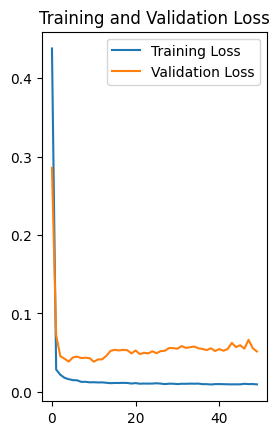

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
126/126 [==============================] - 16s 85ms/step - loss: 0.1812 - val_loss: 3.4867
Epoch 2/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0188 - val_loss: 6.2255
Epoch 3/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0076 - val_loss: 0.0568
Epoch 4/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0066 - val_loss: 1.1362
Epoch 5/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0063 - val_loss: 2.0203
Epoch 6/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0060 - val_loss: 2.1171
Epoch 7/50
126/126 [==============================] - 10s 79ms/step - loss: 0.0055 - val_loss: 2.3326
Epoch 8/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0055 - val_loss: 2.3253
Epoch 9/50
126/126 [==============================] - 10s 78ms/step - loss: 0.0049 - val_loss: 2.4751
Epoch 10/50
126/126 [==============================] - 10s 79ms/step - loss: 0.004

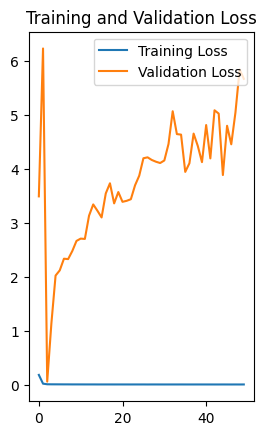

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
46/46 [==============================] - 9s 91ms/step - loss: 0.2108 - val_loss: 4.3516
Epoch 2/50
46/46 [==============================] - 4s 81ms/step - loss: 0.0844 - val_loss: 4.9464
Epoch 3/50
46/46 [==============================] - 4s 77ms/step - loss: 0.0129 - val_loss: 4.4197
Epoch 4/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0096 - val_loss: 4.2216
Epoch 5/50
46/46 [==============================] - 4s 81ms/step - loss: 0.0078 - val_loss: 4.2234
Epoch 6/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0072 - val_loss: 4.2253
Epoch 7/50
46/46 [==============================] - 4s 80ms/step - loss: 0.0073 - val_loss: 4.2293
Epoch 8/50
46/46 [==============================] - 4s 81ms/step - loss: 0.0069 - val_loss: 4.2307
Epoch 9/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0067 - val_loss: 4.2334
Epoch 10/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0066 - val_loss: 4.2366
Epoch 11/

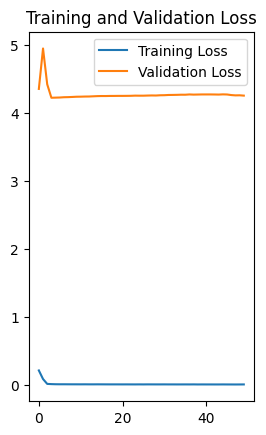

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

Epoch 1/50
74/74 [==============================] - 12s 89ms/step - loss: 0.4637 - val_loss: 2.2972
Epoch 2/50
74/74 [==============================] - 6s 81ms/step - loss: 0.0700 - val_loss: 6.7560
Epoch 3/50
74/74 [==============================] - 6s 81ms/step - loss: 0.0328 - val_loss: 0.5868
Epoch 4/50
74/74 [==============================] - 6s 80ms/step - loss: 0.0303 - val_loss: 0.4551
Epoch 5/50
74/74 [==============================] - 6s 80ms/step - loss: 0.0282 - val_loss: 0.4128
Epoch 6/50
74/74 [==============================] - 6s 82ms/step - loss: 0.0269 - val_loss: 0.5118
Epoch 7/50
74/74 [==============================] - 6s 81ms/step - loss: 0.0265 - val_loss: 1.1429
Epoch 8/50
74/74 [==============================] - 6s 83ms/step - loss: 0.0239 - val_loss: 1.6048
Epoch 9/50
74/74 [==============================] - 6s 81ms/step - loss: 0.0242 - val_loss: 1.1800
Epoch 10/50
74/74 [==============================] - 6s 83ms/step - loss: 0.0228 - val_loss: 1.4619
Epoch 11

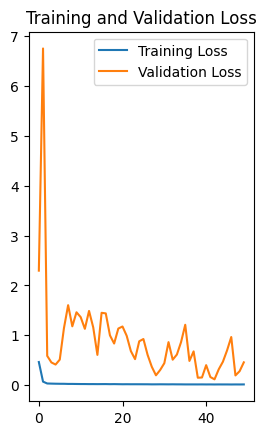

[Timestamp('2023-12-04 00:00:00', freq='D'), Timestamp('2023-12-05 00:00:00', freq='D'), Timestamp('2023-12-06 00:00:00', freq='D'), Timestamp('2023-12-07 00:00:00', freq='D'), Timestamp('2023-12-08 00:00:00', freq='D'), Timestamp('2023-12-09 00:00:00', freq='D'), Timestamp('2023-12-10 00:00:00', freq='D'), Timestamp('2023-12-11 00:00:00', freq='D'), Timestamp('2023-12-12 00:00:00', freq='D'), Timestamp('2023-12-13 00:00:00', freq='D'), Timestamp('2023-12-14 00:00:00', freq='D'), Timestamp('2023-12-15 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-17 00:00:00', freq='D'), Timestamp('2023-12-18 00:00:00', freq='D'), Timestamp('2023-12-19 00:00:00', freq='D'), Timestamp('2023-12-20 00:00:00', freq='D'), Timestamp('2023-12-21 00:00:00', freq='D'), Timestamp('2023-12-22 00:00:00', freq='D'), Timestamp('2023-12-23 00:00:00', freq='D'), Timestamp('2023-12-24 00:00:00', freq='D'), Timestamp('2023-12-25 00:00:00', freq='D'), Timestamp('2023-12-26 00:00:00'

In [ ]:
nodes=[1000,1000,50,50]
drop=0.6
# stacked_lstm('NET',nodes,drop,50)
SITM=stacked_lstm('SITM',nodes,drop,50)
MDB=stacked_lstm('MDB',nodes,drop,50)
SHOP=stacked_lstm('SHOP',nodes,drop,50)
NET=stacked_lstm('NET',nodes,drop,50)
ROKU=stacked_lstm('ROKU',nodes,drop,50)
MLM=stacked_lstm('MLM',nodes,drop,50)
LIN=stacked_lstm('LIN',nodes,drop,50)
NBR=stacked_lstm('NBR',nodes,drop,50)
TPL=stacked_lstm('TPL',nodes,drop,50)
PECO=stacked_lstm('PECO',nodes,drop,50)
MELI=stacked_lstm('MELI',nodes,drop,50)
TSLA=stacked_lstm('TSLA',nodes,drop,50)
MSEX=stacked_lstm('MSEX',nodes,drop,50)
AWR=stacked_lstm('AWR',nodes,drop,50)
NWN=stacked_lstm('NWN',nodes,drop,50)
SJW=stacked_lstm('SJW',nodes,drop,50)
CPK=stacked_lstm('CPK',nodes,drop,50)
OTTR=stacked_lstm('OTTR',nodes,drop,50)
CWT=stacked_lstm('CWT',nodes,drop,50)
UTL=stacked_lstm('UTL',nodes,drop,50)
COST=stacked_lstm('COST',nodes,drop,50)
ELF=stacked_lstm('ELF',nodes,drop,50)
CUBI=stacked_lstm('CUBI',nodes,drop,50)

In [ ]:
#join the above dataframes into one
SITM


,Date,Open
0,2023-12-04,129.205719
1,2023-12-05,127.213959
2,2023-12-06,125.608940
3,2023-12-07,124.498917
4,2023-12-08,123.875748
...,...,...
85,2024-02-27,122.899559
86,2024-02-28,123.796432
87,2024-02-29,124.415619
88,2024-03-01,124.423767


In [ ]:
SITM.rename(columns={"Open": "SITM"}, inplace=True)

MDB.rename(columns={"Open": "MDB"}, inplace=True)
MDB=MDB.drop(['Date'], axis=1)

SHOP.rename(columns={"Open": "SHOP"}, inplace=True)
SHOP=SHOP.drop(['Date'], axis=1)

NET.rename(columns={"Open": "NET"}, inplace=True)
NET=NET.drop(['Date'], axis=1)

ROKU.rename(columns={"Open": "ROKU"}, inplace=True)
ROKU=ROKU.drop(['Date'], axis=1)

MLM.rename(columns={"Open": "MLM"}, inplace=True)
MLM=MLM.drop(['Date'], axis=1)


LIN.rename(columns={"Open": "LIN"}, inplace=True)
LIN=LIN.drop(['Date'], axis=1)

NBR.rename(columns={"Open": "NBR"}, inplace=True)
NBR=NBR.drop(['Date'], axis=1)

TPL.rename(columns={"Open": "TPL"}, inplace=True)
TPL=TPL.drop(['Date'], axis=1)

PECO.rename(columns={"Open": "PECO"}, inplace=True)
PECO=PECO.drop(['Date'], axis=1)

MELI.rename(columns={"Open": "MELI"}, inplace=True)
MELI=MELI.drop(['Date'], axis=1)

TSLA.rename(columns={"Open": "TSLA"}, inplace=True)
TSLA=TSLA.drop(['Date'], axis=1)


MSEX.rename(columns={"Open": "MSEX"}, inplace=True)
MSEX=MSEX.drop(['Date'], axis=1)

AWR.rename(columns={"Open": "AWR"}, inplace=True)
AWR=AWR.drop(['Date'], axis=1)


NWN.rename(columns={"Open": "NWN"}, inplace=True)
NWN=NWN.drop(['Date'], axis=1)

SJW.rename(columns={"Open": "SJW"}, inplace=True)
SJW=SJW.drop(['Date'], axis=1)

CPK.rename(columns={"Open": "CPK"}, inplace=True)
CPK=CPK.drop(['Date'], axis=1)

OTTR.rename(columns={"Open": "OTTR"}, inplace=True)
OTTR=OTTR.drop(['Date'], axis=1)

CWT.rename(columns={"Open": "CWT"}, inplace=True)
CWT=CWT.drop(['Date'], axis=1)


CUBI.rename(columns={"Open": "CUBI"}, inplace=True)
CUBI=CUBI.drop(['Date'], axis=1)


ELF.rename(columns={"Open": "ELF"}, inplace=True)
ELF=ELF.drop(['Date'], axis=1)


COST.rename(columns={"Open": "COST"}, inplace=True)
COST=COST.drop(['Date'], axis=1)


UTL.rename(columns={"Open": "UTL"}, inplace=True)
UTL=UTL.drop(['Date'], axis=1)






In [ ]:
result = pd.concat([SITM, MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,PECO,MELI,TSLA,MSEX,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL], axis=1)


In [ ]:
result

,Date,SITM,MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,...,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL
0,2023-12-04,128.138306,387.233368,66.585899,69.446396,85.077538,433.913177,419.220703,130.792389,1261.204712,...,77.784737,41.575905,63.249638,116.185387,82.934235,51.960960,41.319408,33.225449,731.535767,50.684166
1,2023-12-05,129.233749,381.998627,64.808853,69.263260,83.610252,437.003571,418.930573,131.033539,1295.704956,...,77.611443,41.339622,62.434685,115.304810,83.529503,52.124603,40.983040,33.265984,728.369019,50.501846
2,2023-12-06,130.703461,377.281067,63.196980,68.803192,82.040863,439.839294,418.436920,131.080353,1334.181152,...,77.851982,41.156200,61.771721,114.627113,83.975044,52.388100,40.588768,33.305511,727.230896,50.363792
3,2023-12-07,132.548325,372.471039,61.916466,68.115730,80.679993,442.059265,417.283569,130.756683,1370.672607,...,78.573006,41.035988,61.389801,113.838577,84.313072,52.720669,40.099674,33.331696,725.211731,50.238476
4,2023-12-08,134.449081,366.742554,61.137524,67.277153,79.469154,443.969666,416.614319,131.748505,1396.445923,...,79.700226,40.968494,61.270641,113.061111,84.535675,53.035942,39.522594,33.363895,723.439941,50.060123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024-02-27,114.699692,430.238678,77.986626,80.627777,103.126747,443.540588,456.741333,96.661957,1108.804321,...,78.504494,37.950069,66.913528,88.035851,74.229889,52.295612,48.987480,33.188160,812.063843,49.678810
86,2024-02-28,112.705444,435.798340,78.092316,80.700180,103.090118,443.599213,456.743347,94.654755,1085.526367,...,78.843407,38.336868,67.292625,88.601105,74.285347,52.498055,49.437531,33.202770,818.460510,49.918758
87,2024-02-29,111.218513,442.916504,78.174126,81.178589,103.006310,446.954468,455.988617,92.835236,1066.698608,...,79.329956,38.658348,67.559662,89.414520,74.330933,52.710293,49.702911,33.222885,825.204895,50.143814
88,2024-03-01,110.571587,452.054230,78.325874,81.411446,102.881020,451.510345,455.401062,91.766266,1060.222412,...,79.451027,38.921738,67.734032,90.426682,74.342003,52.832085,49.947590,33.244968,831.597351,50.319141


In [ ]:
result.to_csv('forecast_results.csv', index=False)


In [ ]:
result.reset_index(drop=True)

,Date,SITM,MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,...,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL
0,2023-12-04,128.138306,387.233368,66.585899,69.446396,85.077538,433.913177,419.220703,130.792389,1261.204712,...,77.784737,41.575905,63.249638,116.185387,82.934235,51.960960,41.319408,33.225449,731.535767,50.684166
1,2023-12-05,129.233749,381.998627,64.808853,69.263260,83.610252,437.003571,418.930573,131.033539,1295.704956,...,77.611443,41.339622,62.434685,115.304810,83.529503,52.124603,40.983040,33.265984,728.369019,50.501846
2,2023-12-06,130.703461,377.281067,63.196980,68.803192,82.040863,439.839294,418.436920,131.080353,1334.181152,...,77.851982,41.156200,61.771721,114.627113,83.975044,52.388100,40.588768,33.305511,727.230896,50.363792
3,2023-12-07,132.548325,372.471039,61.916466,68.115730,80.679993,442.059265,417.283569,130.756683,1370.672607,...,78.573006,41.035988,61.389801,113.838577,84.313072,52.720669,40.099674,33.331696,725.211731,50.238476
4,2023-12-08,134.449081,366.742554,61.137524,67.277153,79.469154,443.969666,416.614319,131.748505,1396.445923,...,79.700226,40.968494,61.270641,113.061111,84.535675,53.035942,39.522594,33.363895,723.439941,50.060123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024-02-27,114.699692,430.238678,77.986626,80.627777,103.126747,443.540588,456.741333,96.661957,1108.804321,...,78.504494,37.950069,66.913528,88.035851,74.229889,52.295612,48.987480,33.188160,812.063843,49.678810
86,2024-02-28,112.705444,435.798340,78.092316,80.700180,103.090118,443.599213,456.743347,94.654755,1085.526367,...,78.843407,38.336868,67.292625,88.601105,74.285347,52.498055,49.437531,33.202770,818.460510,49.918758
87,2024-02-29,111.218513,442.916504,78.174126,81.178589,103.006310,446.954468,455.988617,92.835236,1066.698608,...,79.329956,38.658348,67.559662,89.414520,74.330933,52.710293,49.702911,33.222885,825.204895,50.143814
88,2024-03-01,110.571587,452.054230,78.325874,81.411446,102.881020,451.510345,455.401062,91.766266,1060.222412,...,79.451027,38.921738,67.734032,90.426682,74.342003,52.832085,49.947590,33.244968,831.597351,50.319141


In [ ]:
result.set_index('Date')
result.reset_index(drop=True)
results = result.dtypes
print(results)

Date    datetime64[ns]
SITM           float32
MDB            float32
SHOP           float32
NET            float32
ROKU           float32
MLM            float32
LIN            float32
NBR            float32
TPL            float32
PECO           float32
MELI           float32
TSLA           float32
MSEX           float32
AWR            float32
NWN            float32
SJW            float32
CPK            float32
OTTR           float32
CWT            float32
CUBI           float32
ELF            float32
COST           float32
UTL            float32
dtype: object


In [ ]:
result['Date'] = result['Date'].dt.strftime('%d%m%Y')


In [ ]:
results = result.dtypes
print(results)

Date     object
SITM    float32
MDB     float32
SHOP    float32
NET     float32
ROKU    float32
MLM     float32
LIN     float32
NBR     float32
TPL     float32
PECO    float32
MELI    float32
TSLA    float32
MSEX    float32
AWR     float32
NWN     float32
SJW     float32
CPK     float32
OTTR    float32
CWT     float32
CUBI    float32
ELF     float32
COST    float32
UTL     float32
dtype: object


In [ ]:
#Calculate Lognormal Returns
forecast_prices=result.iloc[:,1:]
log_returns=np.log(forecast_prices/forecast_prices.shift(1))

In [ ]:
log_returns.rename(columns={"Open":"STIM"})

,SITM,MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,PECO,...,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008513,-0.013611,-0.027051,-0.002641,-0.017397,0.007097,-0.000692,0.001842,0.026987,0.001892,...,-0.002230,-0.005699,-0.012968,-0.007608,0.007152,0.003144,-0.008174,0.001219,-0.004338,-0.003604
2,0.011308,-0.012427,-0.025186,-0.006664,-0.018949,0.006468,-0.001179,0.000357,0.029263,0.002694,...,0.003095,-0.004447,-0.010675,-0.005895,0.005320,0.005042,-0.009667,0.001188,-0.001564,-0.002737
3,0.014016,-0.012831,-0.020470,-0.010042,-0.016727,0.005035,-0.002760,-0.002472,0.026984,0.002642,...,0.009219,-0.002925,-0.006202,-0.006903,0.004017,0.006328,-0.012123,0.000786,-0.002780,-0.002491
4,0.014238,-0.015499,-0.012660,-0.012387,-0.015122,0.004312,-0.001605,0.007557,0.018629,0.001901,...,0.014244,-0.001646,-0.001943,-0.006853,0.002637,0.005962,-0.014496,0.000966,-0.002446,-0.003556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.019316,0.010477,0.002001,0.001374,0.003368,0.000182,0.000094,-0.022132,-0.022883,0.001583,...,0.001904,0.008665,0.004638,0.004914,0.001808,0.003514,0.010849,0.000096,0.007077,0.002525
86,-0.017540,0.012840,0.001354,0.000898,-0.000355,0.000132,0.000004,-0.020984,-0.021217,0.002105,...,0.004308,0.010141,0.005649,0.006400,0.000747,0.003864,0.009145,0.000440,0.007846,0.004818
87,-0.013281,0.016202,0.001047,0.005911,-0.000813,0.007535,-0.001654,-0.019410,-0.017497,0.002046,...,0.006152,0.008351,0.003960,0.009139,0.000614,0.004035,0.005354,0.000606,0.008207,0.004498
88,-0.005834,0.020421,0.001939,0.002864,-0.001217,0.010142,-0.001289,-0.011582,-0.006090,0.002347,...,0.001525,0.006790,0.002578,0.011256,0.000149,0.002308,0.004911,0.000664,0.007717,0.003490


In [ ]:
#drop any missing log values
log_returns=log_returns.dropna()

In [ ]:
#do multiply by 252 to annulize returns
cov_matrix=log_returns.cov()*252
print(cov_matrix)

          SITM       MDB      SHOP       NET      ROKU       MLM       LIN  \
SITM  0.039631  0.006280  0.013771  0.008802  0.011057  0.005983  0.002673   
MDB   0.006280  0.090668  0.036369  0.027840  0.033489  0.016924  0.005567   
SHOP  0.013771  0.036369  0.042410  0.025220  0.032756 -0.001362  0.009080   
NET   0.008802  0.027840  0.025220  0.033970  0.027622  0.007284  0.006717   
ROKU  0.011057  0.033489  0.032756  0.027622  0.066733  0.008992  0.008239   
MLM   0.005983  0.016924 -0.001362  0.007284  0.008992  0.028583 -0.001025   
LIN   0.002673  0.005567  0.009080  0.006717  0.008239 -0.001025  0.003021   
NBR   0.011220  0.000821  0.009606  0.007398 -0.002926 -0.009000  0.002451   
TPL   0.028693 -0.023243 -0.003461  0.010314  0.018271  0.009488  0.004313   
PECO -0.000764 -0.000062  0.000924  0.002460  0.003137 -0.000343  0.000833   
MELI  0.000372  0.013931  0.011032  0.010038  0.014880  0.003776  0.003936   
TSLA  0.008794  0.012040  0.021000  0.013386  0.012657 -0.003422

In [ ]:
from re import S
#calcuate portfolio performance metrics

# 1. portfolio risk by portfolio Std

def standard_deviation(weights,cov_matrix):
  variance=weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

# 2. expected return -- based on historical returns

def expected_return (weights,log_returns):
  return np.sum(log_returns.mean()*weights)*252


In [ ]:
#calcualte the sharp ratio

def sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate):
  return(expected_return (weights,log_returns)-risk_free_rate)/standard_deviation(weights,cov_matrix)

In [ ]:
pip install fredapi

In [ ]:
#set the risk free rate
from fredapi import Fred
# easy way the risk free rate is 2% -- this is what is in the finance textbooks
#use the federal reserve api, fred api https://fred.stlouisfed.org/docs/api/api_key.html

fred=Fred(api_key='e1e8a9ea3c123afd06c93581bccf89e8')
ten_year_treasury_rate=fred.get_series_latest_release('GS10')/100
risk_free_rate=ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.045


In [ ]:
#define function to minimze (negative Sharpe Ratio)
#using the
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
  return -sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate)

In [ ]:
#set the constraints and bounds
#sum of all portfolio weights must equal 1
constraints={'type':'eq','fun':lambda weights:np.sum(weights)-1}

#lower and upper bound for each weights, 0 for lower means you cant short any of the assets, 0.5 for higher means that any one of these stocks cant be more than 50% of the portfolio
bounds=[(0,0.5) for _ in range(len(Ticker_List))]


In [ ]:
#set the initial weights -- each one is just equally weighted

initial_weights = np.array([1/len(Ticker_List)]*len(Ticker_List))
initial_weights

array([0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826])

In [ ]:
#get the optimal weights to maximize sharp ratio
from scipy.optimize import minimize
#scipi doesnt have a maximize function, so if you do the smallest negative sharp ratio its same as maximize
optimized_results=minimize(neg_sharpe_ratio, initial_weights,args=(log_returns,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)

In [ ]:
#get optimal weights

optimal_weights=optimized_results.x

In [ ]:
#display the analytics of the portfolio

print("Optimal Weights:")
for ticker, weight in zip(Ticker_List, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SITM: 0.0000
MDB: 0.0000
SHOP: 0.0000
NET: 0.0000
ROKU: 0.0000
MLM: 0.0244
LIN: 0.0000
NBR: 0.0000
TPL: 0.0000
PECO: 0.0000
MELI: 0.3335
TSLA: 0.0000
MSEX: 0.0000
AWR: 0.0000
NWN: 0.0000
SJW: 0.0321
CPK: 0.0000
OTTR: 0.0000
CWT: 0.0000
UTL: 0.1100
COST: 0.0000
ELF: 0.5000
CUBI: 0.0000
Expected Annual Return: 0.4456
Expected Volatility: 0.0609
Sharpe Ratio: 6.5772


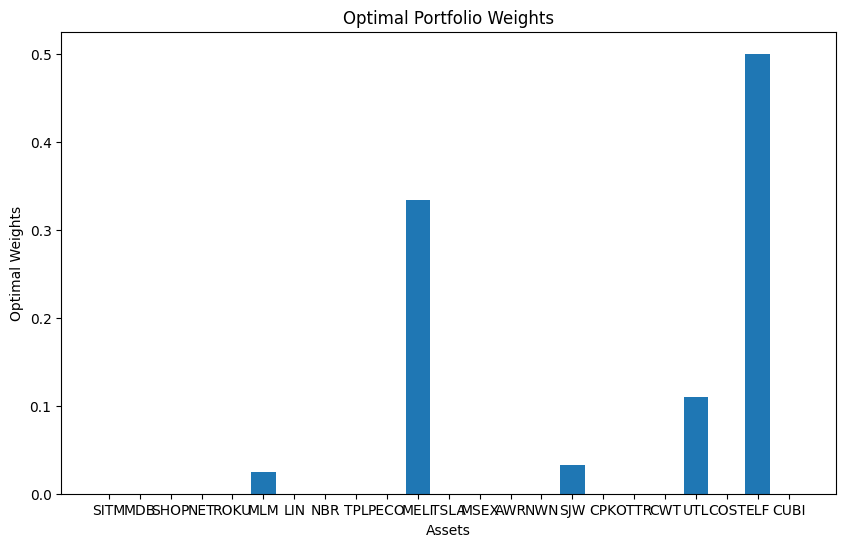

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(Ticker_List, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [ ]:
print(results)

Date     object
SITM    float32
MDB     float32
SHOP    float32
NET     float32
ROKU    float32
MLM     float32
LIN     float32
NBR     float32
TPL     float32
PECO    float32
MELI    float32
TSLA    float32
MSEX    float32
AWR     float32
NWN     float32
SJW     float32
CPK     float32
OTTR    float32
CWT     float32
CUBI    float32
ELF     float32
COST    float32
UTL     float32
dtype: object


In [ ]:
forecast_prices

,SITM,MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,PECO,...,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL
0,128.138306,387.233368,66.585899,69.446396,85.077538,433.913177,419.220703,130.792389,1261.204712,33.560760,...,77.784737,41.575905,63.249638,116.185387,82.934235,51.960960,41.319408,33.225449,731.535767,50.684166
1,129.233749,381.998627,64.808853,69.263260,83.610252,437.003571,418.930573,131.033539,1295.704956,33.624313,...,77.611443,41.339622,62.434685,115.304810,83.529503,52.124603,40.983040,33.265984,728.369019,50.501846
2,130.703461,377.281067,63.196980,68.803192,82.040863,439.839294,418.436920,131.080353,1334.181152,33.715031,...,77.851982,41.156200,61.771721,114.627113,83.975044,52.388100,40.588768,33.305511,727.230896,50.363792
3,132.548325,372.471039,61.916466,68.115730,80.679993,442.059265,417.283569,130.756683,1370.672607,33.804218,...,78.573006,41.035988,61.389801,113.838577,84.313072,52.720669,40.099674,33.331696,725.211731,50.238476
4,134.449081,366.742554,61.137524,67.277153,79.469154,443.969666,416.614319,131.748505,1396.445923,33.868538,...,79.700226,40.968494,61.270641,113.061111,84.535675,53.035942,39.522594,33.363895,723.439941,50.060123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,114.699692,430.238678,77.986626,80.627777,103.126747,443.540588,456.741333,96.661957,1108.804321,33.898479,...,78.504494,37.950069,66.913528,88.035851,74.229889,52.295612,48.987480,33.188160,812.063843,49.678810
86,112.705444,435.798340,78.092316,80.700180,103.090118,443.599213,456.743347,94.654755,1085.526367,33.969906,...,78.843407,38.336868,67.292625,88.601105,74.285347,52.498055,49.437531,33.202770,818.460510,49.918758
87,111.218513,442.916504,78.174126,81.178589,103.006310,446.954468,455.988617,92.835236,1066.698608,34.039474,...,79.329956,38.658348,67.559662,89.414520,74.330933,52.710293,49.702911,33.222885,825.204895,50.143814
88,110.571587,452.054230,78.325874,81.411446,102.881020,451.510345,455.401062,91.766266,1060.222412,34.119476,...,79.451027,38.921738,67.734032,90.426682,74.342003,52.832085,49.947590,33.244968,831.597351,50.319141


In [ ]:
result

,Date,SITM,MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,...,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL
0,04122023,128.138306,387.233368,66.585899,69.446396,85.077538,433.913177,419.220703,130.792389,1261.204712,...,77.784737,41.575905,63.249638,116.185387,82.934235,51.960960,41.319408,33.225449,731.535767,50.684166
1,05122023,129.233749,381.998627,64.808853,69.263260,83.610252,437.003571,418.930573,131.033539,1295.704956,...,77.611443,41.339622,62.434685,115.304810,83.529503,52.124603,40.983040,33.265984,728.369019,50.501846
2,06122023,130.703461,377.281067,63.196980,68.803192,82.040863,439.839294,418.436920,131.080353,1334.181152,...,77.851982,41.156200,61.771721,114.627113,83.975044,52.388100,40.588768,33.305511,727.230896,50.363792
3,07122023,132.548325,372.471039,61.916466,68.115730,80.679993,442.059265,417.283569,130.756683,1370.672607,...,78.573006,41.035988,61.389801,113.838577,84.313072,52.720669,40.099674,33.331696,725.211731,50.238476
4,08122023,134.449081,366.742554,61.137524,67.277153,79.469154,443.969666,416.614319,131.748505,1396.445923,...,79.700226,40.968494,61.270641,113.061111,84.535675,53.035942,39.522594,33.363895,723.439941,50.060123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,27022024,114.699692,430.238678,77.986626,80.627777,103.126747,443.540588,456.741333,96.661957,1108.804321,...,78.504494,37.950069,66.913528,88.035851,74.229889,52.295612,48.987480,33.188160,812.063843,49.678810
86,28022024,112.705444,435.798340,78.092316,80.700180,103.090118,443.599213,456.743347,94.654755,1085.526367,...,78.843407,38.336868,67.292625,88.601105,74.285347,52.498055,49.437531,33.202770,818.460510,49.918758
87,29022024,111.218513,442.916504,78.174126,81.178589,103.006310,446.954468,455.988617,92.835236,1066.698608,...,79.329956,38.658348,67.559662,89.414520,74.330933,52.710293,49.702911,33.222885,825.204895,50.143814
88,01032024,110.571587,452.054230,78.325874,81.411446,102.881020,451.510345,455.401062,91.766266,1060.222412,...,79.451027,38.921738,67.734032,90.426682,74.342003,52.832085,49.947590,33.244968,831.597351,50.319141


In [ ]:
predicted_resutls=result.iloc[0:13,1:]

In [ ]:
predicted_resutls

,SITM,MDB,SHOP,NET,ROKU,MLM,LIN,NBR,TPL,PECO,...,AWR,NWN,SJW,CPK,OTTR,CWT,CUBI,ELF,COST,UTL
0,128.138306,387.233368,66.585899,69.446396,85.077538,433.913177,419.220703,130.792389,1261.204712,33.560760,...,77.784737,41.575905,63.249638,116.185387,82.934235,51.960960,41.319408,33.225449,731.535767,50.684166
1,129.233749,381.998627,64.808853,69.263260,83.610252,437.003571,418.930573,131.033539,1295.704956,33.624313,...,77.611443,41.339622,62.434685,115.304810,83.529503,52.124603,40.983040,33.265984,728.369019,50.501846
2,130.703461,377.281067,63.196980,68.803192,82.040863,439.839294,418.436920,131.080353,1334.181152,33.715031,...,77.851982,41.156200,61.771721,114.627113,83.975044,52.388100,40.588768,33.305511,727.230896,50.363792
3,132.548325,372.471039,61.916466,68.115730,80.679993,442.059265,417.283569,130.756683,1370.672607,33.804218,...,78.573006,41.035988,61.389801,113.838577,84.313072,52.720669,40.099674,33.331696,725.211731,50.238476
4,134.449081,366.742554,61.137524,67.277153,79.469154,443.969666,416.614319,131.748505,1396.445923,33.868538,...,79.700226,40.968494,61.270641,113.061111,84.535675,53.035942,39.522594,33.363895,723.439941,50.060123
5,135.576584,362.349335,60.914902,66.383163,77.839844,444.529510,416.120239,131.502228,1409.477905,33.933643,...,81.149467,40.919819,61.644955,112.383484,84.562881,53.427349,38.902889,33.387962,721.946533,49.873325
6,135.958267,359.128845,61.076786,65.392220,82.478073,442.819824,415.072662,130.514801,1408.909790,33.959511,...,82.693298,40.871288,62.237068,111.832977,84.290474,53.708797,38.356010,33.397686,720.624817,49.657658
7,136.199142,357.949310,61.259865,64.465530,84.304085,436.976624,413.912750,129.480072,1392.541138,33.915764,...,84.338348,40.800987,68.969200,111.406006,83.646561,51.946918,37.670338,33.399925,719.805786,49.389767
8,135.322449,359.987793,61.208153,63.506035,83.645851,428.681854,412.556549,128.567047,1358.594116,33.828903,...,84.429153,40.698658,68.689079,110.923355,82.672569,51.940125,36.946415,33.386410,719.321533,49.262115
9,134.372589,357.211395,61.277782,62.362606,82.746208,419.920135,411.925446,128.093475,1308.798950,33.679176,...,84.551231,40.598896,68.354431,110.391037,81.585358,51.921242,36.252766,33.334328,719.496765,49.185757


          SITM       MDB      SHOP       NET      ROKU       MLM       LIN  \
SITM  0.017686 -0.011298 -0.017289 -0.002937 -0.008390  0.018118 -0.000360   
MDB  -0.011298  0.011103  0.012627 -0.001437  0.006074 -0.012765 -0.000283   
SHOP -0.017289  0.012627  0.032956 -0.009036  0.031708 -0.024175 -0.000316   
NET  -0.002937 -0.001437 -0.009036  0.026046 -0.012044  0.009396  0.001341   
ROKU -0.008390  0.006074  0.031708 -0.012044  0.128611 -0.013749 -0.002539   
MLM   0.018118 -0.012765 -0.024175  0.009396 -0.013749  0.028995  0.000346   
LIN  -0.000360 -0.000283 -0.000316  0.001341 -0.002539  0.000346  0.000293   
NBR   0.005509 -0.004495 -0.007752  0.001329 -0.014845  0.007358  0.000489   
TPL   0.053520 -0.035694 -0.064352  0.001634 -0.022555  0.060996 -0.001325   
PECO  0.006676 -0.004396 -0.006592 -0.001840 -0.000396  0.006139 -0.000290   
MELI  0.014200 -0.010875 -0.015600 -0.002369 -0.014573  0.014358  0.000153   
TSLA -0.002916  0.002695  0.006238 -0.000646 -0.000262 -0.003646

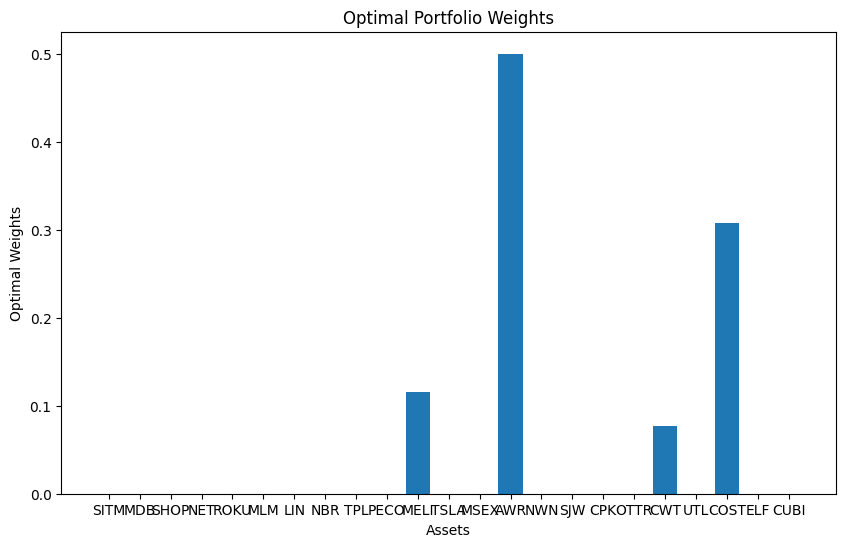

In [ ]:
#optimize above portfolio
from scipy.optimize import minimize

#Calculate Lognormal Returns
log_returns=np.log(predicted_resutls/predicted_resutls.shift(1))

#drop any missing log values
log_returns=log_returns.dropna()

#do multiply by 252 to annulize returns
cov_matrix=log_returns.cov()*252
print(cov_matrix)

from re import S
#calcuate portfolio performance metrics

# 1. portfolio risk by portfolio Std

def standard_deviation(weights,cov_matrix):
  variance=weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

# 2. expected return -- based on historical returns

def expected_return (weights,log_returns):
  return np.sum(log_returns.mean()*weights)*252

#calcualte the sharp ratio

def sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate):
  return(expected_return (weights,log_returns)-risk_free_rate)/standard_deviation(weights,cov_matrix)


  #set the risk free rate
from fredapi import Fred
# easy way the risk free rate is 2% -- this is what is in the finance textbooks
#use the federal reserve api, fred api https://fred.stlouisfed.org/docs/api/api_key.html

fred=Fred(api_key='57b3e5a6eab0ce7cec8584d4cb4e26d0')
ten_year_treasury_rate=fred.get_series_latest_release('GS10')/100
risk_free_rate=ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

#define function to minimze (negative Sharpe Ratio)
#using the
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
  return -sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate)

#set the constraints and bounds
#sum of all portfolio weights must equal 1
constraints={'type':'eq','fun':lambda weights:np.sum(weights)-1}

#lower and upper bound for each weights, 0 for lower means you cant short any of the assets, 0.5 for higher means that any one of these stocks cant be more than 50% of the portfolio
bounds=[(0,0.5) for _ in range(len(Ticker_List))]

#set the initial weights
initial_weights=np.array([1/len(Ticker_List) for _ in range(len(Ticker_List))])

#get the optimal weights to maximize sharp ratio
#scipi doesnt have a maximize function, so if you do the smallest negative sharp ratio its same as maximize
optimized_results=minimize(neg_sharpe_ratio, initial_weights,args=(log_returns,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)


#get optimal weights

optimal_weights=optimized_results.x


#display the analytics of the portfolio

print("Optimal Weights:")
for ticker, weight in zip(Ticker_List, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(Ticker_List, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [ ]:
#real life

#optimize above portfolio

from scipy.optimize import minimize
from datetime import datetime,timedelta

Ticker_List=['MELI','AWR','CWT','COST']
end_date= datetime.today()
start_date= end_date - timedelta(days=13)
print(start_date)

real_results=pd.DataFrame()

#Download adjusted closed prices
adj_close_df=pd.DataFrame()
for ticker in Ticker_List:
  data=yf.download(ticker,start=start_date,end=end_date)
  real_results[ticker]=data['Close']


#Calculate Lognormal Returns
log_returns=np.log(real_results/real_results.shift(1))

#drop any missing log values
log_returns=log_returns.dropna()

#do multiply by 252 to annulize returns
cov_matrix=log_returns.cov()*252
print(cov_matrix)

from re import S
#calcuate portfolio performance metrics

# 1. portfolio risk by portfolio Std

def standard_deviation(weights,cov_matrix):
  variance=weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

# 2. expected return -- based on historical returns

def expected_return (weights,log_returns):
  return np.sum(log_returns.mean()*weights)*252

#calcualte the sharp ratio

def sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate):
  return(expected_return (weights,log_returns)-risk_free_rate)/standard_deviation(weights,cov_matrix)


  #set the risk free rate
from fredapi import Fred
# easy way the risk free rate is 2% -- this is what is in the finance textbooks
#use the federal reserve api, fred api https://fred.stlouisfed.org/docs/api/api_key.html

fred=Fred(api_key='57b3e5a6eab0ce7cec8584d4cb4e26d0')
ten_year_treasury_rate=fred.get_series_latest_release('GS10')/100
risk_free_rate=ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

#define function to minimze (negative Sharpe Ratio)
#using the
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
  return -sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate)

#set the constraints and bounds
#sum of all portfolio weights must equal 1
constraints={'type':'eq','fun':lambda weights:np.sum(weights)-1}

#lower and upper bound for each weights, 0 for lower means you cant short any of the assets, 0.5 for higher means that any one of these stocks cant be more than 50% of the portfolio
bounds=[(0,0.5) for _ in range(len(Ticker_List))]

#set the initial weights
initial_weights=np.array([1/len(Ticker_List) for _ in range(len(Ticker_List))])

#get the optimal weights to maximize sharp ratio
#scipi doesnt have a maximize function, so if you do the smallest negative sharp ratio its same as maximize
optimized_results=minimize(neg_sharpe_ratio, initial_weights,args=(log_returns,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)




2023-12-03 08:43:26.448525
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
          MELI       AWR       CWT      COST
MELI  0.031778  0.000559  0.003287  0.016254
AWR   0.000559  0.049944  0.040633 -0.002969
CWT   0.003287  0.040633  0.038957 -0.010031
COST  0.016254 -0.002969 -0.010031  0.071467
0.045


In [ ]:
#get optimal weights

optimal_weights=optimized_results.x
optimal_weights=np.array([0.1151,0.500,0.768,0.3081])


Optimal Weights:
MELI: 0.1151
AWR: 0.5000
CWT: 0.7680
COST: 0.3081
Expected Annual Return: 0.5374
Expected Volatility: 0.2646
Sharpe Ratio: 1.8608


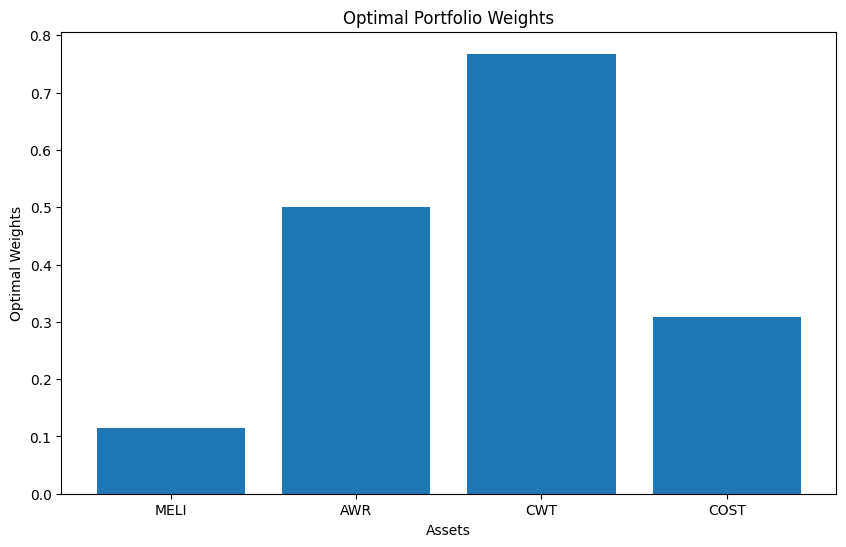

In [ ]:

#display the analytics of the portfolio

print("Optimal Weights:")
for ticker, weight in zip(Ticker_List, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(Ticker_List, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()